In [1]:
from quadcoil import quadcoil# , solve_constrained_IPM
import jax.numpy as jnp
from jax import hessian, eval_shape
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update('jax_enable_x64', True)

In [2]:

from simsopt.mhd import Vmec
filename_pp = 'wout_LandremanPaul2021_QA_lowres'
equil_pp = Vmec(filename_pp + '.nc', keep_all_files=True)
plasma_surface = equil_pp.boundary
net_poloidal_current_amperes = equil_pp.external_current()

f_K at the inflection point: 6738335500000.0
f_B at the inflection point: 0.001515494


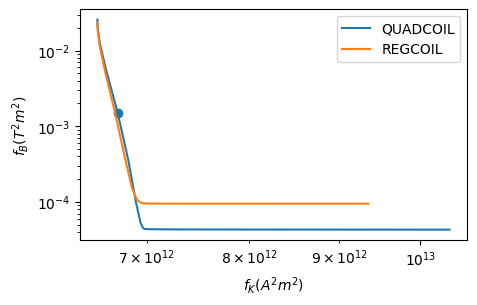

In [3]:
# Settings 
separation = plasma_surface.minor_radius() # 0.1
mpol = 12
ntor = 12
nfp = plasma_surface.nfp
plasma_M_theta = 16
plasma_N_phi = 32
dict = jnp.load('regcoil_' + filename_pp + '.npy', allow_pickle=True).item()
regcoili_qp = dict['regcoili_qp']
time_regcoil_list = dict['time_regcoil_list']
phi_ans_list = dict['phi_ans_list']
f_B_ans_list = dict['f_B_ans_list']
f_K_ans_list = dict['f_K_ans_list']
time_quadcoil_list = dict['time_quadcoil_list']
phi_test_list = dict['phi_test_list']
f_B_test_list = dict['f_B_test_list']
f_K_test_list = dict['f_K_test_list']
# inflection point
i_infl = 12 # np.argmin(f_K_test_list * f_B_test_list)
plt.figure(figsize=(5,3))
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('$f_B(T^2m^2)$')
plt.xlabel('$f_K(A^2m^2)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

In [4]:
# Calculating normalization factors
from quadcoil.quantity import f_max_Phi2, f_B, f_max_Phi, Phi, f_l1_Phi, f_max_Phi4, Phi
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi4 = f_max_Phi4(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^4) =', unit_Phi4, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')
# unit_l1 = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
# print('||Phi||1) =', unit_l1, 'At the inflection point.')

Max(Phi^2) = 72532350000.0 At the inflection point.
Max(Phi^4) = 5.2609424e+21 At the inflection point.
Max(Phi) = 269318.3 At the inflection point.


In [5]:
quadcoil_params = {
    'nfp': plasma_surface.nfp,
    'stellsym': plasma_surface.stellsym,
    'plasma_coil_distance': separation,
    'mpol': mpol,
    'ntor': ntor,
    'plasma_dofs': plasma_surface.get_dofs(),
    'plasma_mpol': plasma_surface.mpol,
    'plasma_ntor': plasma_surface.ntor,
    'net_poloidal_current_amperes': net_poloidal_current_amperes,
    'net_toroidal_current_amperes': 0.,
    'metric_name': 'f_max_Phi',
    'phi_init': phi_test_list[i_infl]['phi'],
    'phi_unit': jnp.max(jnp.abs(phi_test_list[i_infl]['phi'])),
    'objective_name': 'f_max_Phi2', # Minimizing peak dipole density
    'objective_unit': unit_Phi2, # under an f_B constraint
    'constraint_name': ('f_B',),
    'constraint_type': ('<=',),
    'constraint_unit': (f_B_target,),
    'constraint_value': np.array([f_B_target,]),
    # 'maxiter_tot': 20000,
    # 'maxiter_inner': 1000,
}

# Debugging ver. of quadcoil
I think the issue still comes from the magnetic constraints being inactive.
This can't be solved with pre-conditioning. 

I don't think it's something we can easily parameter-tune away, either. How 
would you stop a penalty method from jumping between active constraints?

Before trying anything crazy, let's confirm the issue first.

*Result*

It seems like the correct constraints are active. The Hessian is just ill-conditioned.
To make this work, we have to redefine the coordinate system so that the Hessian
of 

In [6]:
def _precondition_coordinate_by_matrix(hess):
    '''
    Takes a symmetric matrix hess, calculates its SVD, 
    and returns two coordinate transform function, 
    x_to_xp and xp_to_x, so that 
    hess(f(x')) is more well-behaved than hess(f(x)).
    '''
    _, sv, basis = jnp.linalg.svd(hess)
    scale = jnp.sqrt(sv)
    x_to_xp = lambda x: (basis @ x) * scale
    xp_to_x = lambda xp: basis.T @ (xp / scale)
    return x_to_xp, xp_to_x

In [7]:
from quadcoil import (
    merge_callables, get_quantity,
    gen_winding_surface_arc, 
    SurfaceRZFourierJAX, QuadcoilParams, 
    solve_constrained, run_opt_lbfgs,
    is_ndarray, tree_len,
)
from quadcoil.wrapper import _parse_objectives, _parse_constraints
from functools import partial
from quadcoil.quantity import Bnormal
from jax import (
    jacfwd, jacrev, 
    jvp, jit, hessian, 
    config,
    debug,
    flatten_util,
    block_until_ready, make_jaxpr
)
import jax.numpy as jnp
import lineax as lx
config.update('jax_enable_x64', True)

tol_default = 1e-8
tol_default_last = 1e-10
# The list of all static arguments of 
# quadcoil. Also used in the DESC interface.
# All other vars are assumed traced. If you
# would like to add new static options, registering 
# them here will also register them in the DESC _Objective.
QUADCOIL_STATIC_ARGNAMES=[
    'nfp',
    'stellsym',
    'mpol',
    'ntor',
    # - Plasma options
    'plasma_mpol',
    'plasma_ntor',
    # - WS options
    'winding_surface_generator',
    'winding_mpol',
    'winding_ntor',
    # - Objectives
    'objective_name',
    # - Constraints 
    'constraint_name',
    'constraint_type',
    # - Metrics
    'metric_name',
    # - Solver options
    'convex',
    'maxiter_tot',
    'maxiter_inner',
    'maxiter_inner_last',
    'implicit_linear_solver',
    'value_only',
    'verbose',
]
# @partial(jit, static_argnames=QUADCOIL_STATIC_ARGNAMES)
def quadcoil(
    nfp:int,
    stellsym:bool,
    plasma_mpol:int,
    plasma_ntor:int,
    plasma_dofs,
    net_poloidal_current_amperes:float,
    
    # -- Defaults --
    
    # - Quadcoil parameters
    net_toroidal_current_amperes:float=0.,
    mpol:int=6,
    ntor:int=4,
    # Quadpoints to evaluate objectives at
    quadpoints_phi=None,
    quadpoints_theta=None,
    phi_init=None, 
    # Current potential's normalization constant. 
    # By default will be generated from net total current.
    phi_unit=None,
    
    # - Plasma parameters
    plasma_quadpoints_phi=None,
    plasma_quadpoints_theta=None,
    Bnormal_plasma=None,

    # - Winding parameters (offset)
    plasma_coil_distance:float=None,
    winding_surface_generator=gen_winding_surface_arc,

    # - Winding parameters (Providing surface)
    winding_dofs=None,
    winding_mpol:int=6,
    winding_ntor:int=5,
    winding_quadpoints_phi=None,
    winding_quadpoints_theta=None,

    # - Problem setup
    # Quadcoil objective terms, weights, and units
    # objective_unit differ in that they are not differentiated wrt.
    # They also exist to aid readability.
    objective_name='f_B',
    objective_weight=1.,
    objective_unit=None,
    # - Quadcoil constraints
    constraint_name=(),
    constraint_type=(),
    constraint_unit=(),
    constraint_value=jnp.array([]),
    # - Metrics to study
    metric_name=('f_B', 'f_K'),

    # - Solver options
    convex=False,
    c_init:float=1.,
    c_growth_rate:float=2,
    xstop_outer:float=tol_default, # convergence rate tolerance
    # gtol_outer:float=1e-7, # gradient tolerance
    ctol_outer:float=tol_default, # constraint tolerance
    # was 0., but we change this because we changed the logic to req x, u, g 
    # convergence rate to all be smaller than the thres, because sometimes small x results in 
    # large change in f.
    fstop_inner:float=tol_default,
    xstop_inner:float=tol_default,
    gtol_inner:float=tol_default,
    fstop_inner_last:float=0.,
    xstop_inner_last:float=tol_default_last,
    gtol_inner_last:float=tol_default_last,
    svtol:float=tol_default,
    maxiter_tot:int=10000,
    maxiter_inner:int=1000,
    maxiter_inner_last:int=1000,
    # lx.GMRES(rtol=1e-10, atol=1e-10), # Stagnates with default setting
    implicit_linear_solver=lx.AutoLinearSolver(well_posed=True),
    value_only=False,
    verbose=0,
):
    r'''
    Solves a QUADCOIL problem.

    Parameters
    ----------
    nfp : int
        (Static) The number of field periods.
    stellsym : bool
        (Static) Stellarator symmetry.
    plasma_mpol : int
        (Static) The number of poloidal Fourier harmonics in the plasma boundary.
    plasma_ntor : int
        (Static) The number of toroidal Fourier harmonics in the plasma boundary.
    plasma_dofs : ndarray
        (Static) The plasma surface degrees of freedom. Uses the ``simsopt.geo.SurfaceRZFourier.get_dofs()`` convention.
    net_poloidal_current_amperes : float
        (Traced) The net poloidal current :math:`G`.
    net_toroidal_current_amperes : float, optional, default=0
        (Traced) The net toroidal current :math:`I`.
    mpol : int, optional, default=6
        (Static) The number of poloidal Fourier harmonics in the current potential :math:`\Phi_{sv}`.
    ntor : int, optional, default=4
        (Static) The number of toroidal Fourier harmonics in :math:`\Phi_{sv}`.
    quadpoints_phi : ndarray, shape (nphi,), optional, default=None
        (Traced) The poloidal quadrature points on the winding surface to evaluate the objectives at.
        Uses one period from the winding surface by default.
    quadpoints_theta : ndarray, shape (ntheta,), optional, default=None
        (Traced) The toroidal quadrature points on the winding surface to evaluate the objectives at.
        Uses one period from the winding surface by default.
    phi_init : ndarray, optional, default=None
        (Traced) The initial guess. All zeros by default.
    phi_unit : float, optional, default=None
        (Traced) Current potential's normalization constant.
        By default will be generated from total net current.
    plasma_quadpoints_phi : ndarray, shape (nphi_plasma,), optional, default=None
        (Traced) Will be set to ``jnp.linspace(0, 1/nfp, 32, endpoint=False)`` by default.
    plasma_quadpoints_theta : ndarray, shape (ntheta_plasma,), optional, default=None
        (Traced) Will be set to ``jnp.linspace(0, 1, 34, endpoint=False)`` by default.
    Bnormal_plasma : ndarray, shape (nphi, ntheta), optional, default=None
        (Traced) The magnetic field distribution on the plasma surface. Will be filled with zeros by default.
    plasma_coil_distance : float, optional, default=None
        (Traced) The coil-plasma distance. Is set to ``None`` by default, but a value must be provided if ``winding_dofs`` is not provided.
    winding_surface_generator : callable, optional, default=gen_winding_surface_atan
        (Static) The winding surface generator.
    winding_dofs : ndarray, shape (ndof_winding,)
        (Traced) The winding surface degrees of freedom. Uses the ``simsopt.geo.SurfaceRZFourier.get_dofs()`` convention.
        Will be generated using ``winding_surface_generator`` if ``plasma_coil_distance`` is provided. Must be provided otherwise.
    winding_mpol : int, optional, default=6
        (Static) The number of poloidal Fourier harmonics in the winding surface.
    winding_ntor : int, optional, default=5
        (Static) The number of toroidal Fourier harmonics in the winding surface.
    winding_quadpoints_phi : ndarray, shape (nphi_winding,), optional, default=None
        (Traced) Will be set to ``jnp.linspace(0, 1, 32*nfp, endpoint=False)`` by default.
    winding_quadpoints_theta : ndarray, shape (ntheta_winding,), optional, default=None
        (Traced) Will be set to ``jnp.linspace(0, 1, 34, endpoint=False)`` by default.
    objective_name : tuple, optional, default='f_B_normalized_by_Bnormal_IG'
        (Static) The names of the objective functions. Must be a member of ``quadcoil.objective`` that outputs a scalar.
    objective_weight : ndarray, optional, default=None
        (Traced) The weights of the objective functions. Derivatives will be calculated w.r.t. this quantity.
    objective_unit : tuple, optional, default=None
        (Traced) The normalization constants of the objective terms, so that ``f/objective_unit`` is :math:`O(1)`. May contain ``None``
    constraint_name : tuple, optional, default=()
        (Static) The names of the constraint functions. Must be a member of ``quadcoil.objective`` that outputs a scalar.
    constraint_type : tuple, optional, default=()
        (Static) The types of the constraints. Must consist of ``'>='``, ``'<='``, ``'=='`` only.
    constraint_unit : tuple, optional, default=()
        (Traced) The normalization constants of the constraints, so that ``f/constraint_unit`` is :math:`O(1)` May contain ``None``.
    constraint_value : ndarray, optional, default=()
        (Traced) The constraint thresholds. Derivatives will be calculated w.r.t. this quantity.
    metric_name : tuple, optional, default=('f_B', 'f_K')
        (Static) The names of the functions to diagnose the coil configurations with. Will be differentiated w.r.t. other input quantities.
    convex : bool, optional, default=False
        (Static) Whether to assume the problem is convex. When ``True``, QUADCOIL will apply some limited simplifications.
    c_init : float, optional, default=1.
        (Traced) The initial :math:`c` factor. Please see *Constrained Optimization and Lagrange Multiplier Methods* Chapter 3.
    c_growth_rate : float, optional, default=1.2
        (Traced) The growth rate of the :math:`c` factor.
    xstop_outer : float, optional, default=1e-7
        (Traced) ``x`` convergence rate of the outer augmented 
        Lagrangian loop. Terminates when ``dx`` falls below this. 
    ctol_outer : float, optional, default=1e-7
        (Traced) Tolerance of the constraint KKT conditions in the outer
        Lagrangian loop. 
    fstop_inner, fstop_inner_last : float, optional, default=1e-7
        (Traced) ``f`` convergence rate of the inner LBFGS 
        Lagrangian loop. Terminates when ``df`` falls below this. 
    xstop_inner, xstop_inner_last : float, optional, default=0
        (Traced) ``x`` convergence rate of the outer augmented 
        Lagrangian loop. Terminates when ``dx`` falls below this. 
    gtol_inner, gtol_inner_last : float, optional, default=0.1
        (Traced) Gradient tolerance of the inner LBFGS iteration, normalized by the starting gradient.
    svtol : float, optional, default=0.1
        (Traced) Singular-value cut-off threshold during the pre-conditioning. Will treat 
        singular values smaller than ``svtol * jnp.max(s)`` as 0
    maxiter_tot : int, optional, default=50.
        (Static) The maximum of the outer iteration.
    maxiter_inner, maxiter_inner_last : int, optional, default=500
        (Static) The maximum of the inner iteration.
    implicit_linear_solver : lineax.AbstractLinearSolver, optional, default=lineax.AutoLinearSolver(well_posed=True)
        (Static) The lineax linear solver choice for implicit differentiation.
    value_only : bool, optional, default=False
        (Static) When ``True``, skip gradient calculations.
    verbose : int, optional, default=False
        (Static) Print general info when ``verbose==1``. 
        Print inside the outer iteration loop, too, when ``verbose==2``.
    '''
    # ----- Default parameters -----
    if plasma_quadpoints_phi is None:
        plasma_quadpoints_phi = jnp.linspace(0, 1/nfp, 32, endpoint=False)
    if plasma_quadpoints_theta is None:
        plasma_quadpoints_theta = jnp.linspace(0, 1, 34, endpoint=False)
    if winding_quadpoints_phi is None:
        winding_quadpoints_phi = jnp.linspace(0, 1, 32*nfp, endpoint=False)
    if winding_quadpoints_theta is None:
        winding_quadpoints_theta = jnp.linspace(0, 1, 34, endpoint=False)
    if quadpoints_phi is None:
        len_phi = len(winding_quadpoints_phi)//nfp
        quadpoints_phi = winding_quadpoints_phi[:len_phi]
    else:
        quadpoints_phi = quadpoints_phi
    if quadpoints_theta is None:
        quadpoints_theta = winding_quadpoints_theta
    else:
        quadpoints_theta = quadpoints_theta
    if plasma_coil_distance is None and winding_dofs is None:
         raise ValueError('At least one of plasma_coil_distance and winding_dofs must be provided.')
    if plasma_coil_distance is not None and winding_dofs is not None:
         raise ValueError('Only one of plasma_coil_distance and winding_dofs can be provided.')
    
    # ----- Type checking -----
    if not isinstance(objective_name, str):
        if not isinstance(objective_name, tuple):
            raise TypeError('objective_name must be a tuple or string. It is:', type(objective_name))
        if not is_ndarray(objective_weight, 1):
            raise TypeError('objective_weight must be an 1d array. It is:', type(objective_weight))
        # if not isinstance(objective_unit, tuple):
        #     raise TypeError('objective_unit must be a tuple. It is:', type(objective_unit))
        if len(objective_name) != len(objective_weight) or len(objective_name) != len(objective_unit):
            raise ValueError('objective_name, objective_weight, and objective_unit must have the same len')
    else:
        objective_weight = 1.
    if isinstance(metric_name, str):
        metric_name = (metric_name,)
    if not isinstance(constraint_name, tuple):
        raise TypeError('constraint_name must be a tuple. It is:', type(constraint_name))
    if not isinstance(constraint_type, tuple):
        raise TypeError('constraint_type must be a tuple. It is:', type(constraint_type))
    # if not isinstance(constraint_unit, tuple):
    #     raise TypeError('constraint_unit must be a tuple. It is:', type(constraint_unit))
    if (
        len(constraint_name) != len(constraint_type) 
        or len(constraint_name) != len(constraint_unit)
        or len(constraint_name) != len(constraint_value)
    ):
        raise ValueError('constraint_name, constraint_type, constraint_unit, '\
                     'and constraint_value must have the same len. They each '\
                     'are: '
                     + str(constraint_name) + ', ' 
                     + str(constraint_type) + ', ' 
                     + str(constraint_unit) + ', ' 
                     + str(constraint_value) + '.')    
   
    # A dictionary containing all parameters that the problem depends on.
    # These elements will always be in y.
    y_dict_current = {
        'plasma_dofs': plasma_dofs,
        'net_poloidal_current_amperes': net_poloidal_current_amperes,
        'net_toroidal_current_amperes': net_toroidal_current_amperes,
    }
    if not isinstance(objective_name, str):
        y_dict_current['objective_weight'] = jnp.array(objective_weight)
    if len(constraint_name) > 0:
        y_dict_current['constraint_value'] = constraint_value
    # Only differentiate wrt normal field when 
    # it's not zero.
    if Bnormal_plasma is not None:
        if verbose>0:
            debug.print('Maximum Bnormal_plasma: {x}', x=jnp.max(jnp.abs(Bnormal_plasma)))
        y_dict_current['Bnormal_plasma'] = Bnormal_plasma
    # Include winding dofs when it's provided.
    if plasma_coil_distance is None:
        if verbose>0:
            debug.print('Using custom winding surface.')
        y_dict_current['winding_dofs'] = winding_dofs
    else:
        if verbose>0:
            debug.print('Plasma-coil distance (m): {x}', x=plasma_coil_distance)
        y_dict_current['plasma_coil_distance'] = plasma_coil_distance
    # Flatten dict, also, for ease of use during derivatives
    y_flat, unravel_y = flatten_util.ravel_pytree(y_dict_current)
    # ----- Printing inputs -----
    if verbose>0:
        debug.print(
            'Running QUADCOIL in verbose mode \n\n'\
            '----- Input summary ----- \n'\
            'Evaluation phi quadpoint num: {n_quadpoints_phi}\n'\
            'Evaluation theta quadpoint num: {n_quadpoints_theta}\n'\
            'Plasma phi quadpoint num: {n_plasma_quadpoints_phi}\n'\
            'Plasma theta quadpoint num: {n_plasma_quadpoints_theta}\n'\
            'Winding phi quadpoint num: {n_winding_quadpoints_phi}\n'\
            'Winding theta quadpoint num: {n_winding_quadpoints_theta}\n'\
            'Net poloidal current (A): {net_poloidal_current_amperes}\n'\
            'Net toroidal current (A): {net_toroidal_current_amperes}\n'\
            'Constraint names: {constraint_name}\n'\
            'Constraint types: {constraint_type}\n'\
            'Constraint units: {constraint_unit}\n'\
            'Constraint values: {constraint_value}\n'\
            'Objective names: {objective_name}\n'\
            'Objective units: {objective_unit}\n'\
            'Objective weights: {objective_weight}\n'\
            'Numerical parameters:\n'\
            '    c_init: {c_init}\n'\
            '    c_growth_rate: {c_growth_rate}\n'\
            '    xstop_outer: {xstop_outer}\n'\
            # '    gtol_outer: {gtol_outer}\n'\
            '    ctol_outer: {ctol_outer}\n'\
            '    fstop_inner: {fstop_inner}\n'\
            '    xstop_inner: {xstop_inner}\n'\
            '    gtol_inner: {gtol_inner}\n'\
            '    maxiter_tot: {maxiter_tot}\n'\
            '    maxiter_inner: {maxiter_inner}',
            n_quadpoints_phi=len(quadpoints_phi),
            n_quadpoints_theta=len(quadpoints_theta),
            n_plasma_quadpoints_phi=len(plasma_quadpoints_phi),
            n_plasma_quadpoints_theta=len(plasma_quadpoints_theta),
            n_winding_quadpoints_phi=len(winding_quadpoints_phi),
            n_winding_quadpoints_theta=len(winding_quadpoints_theta),
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=net_toroidal_current_amperes,
            constraint_name=constraint_name,
            constraint_type=constraint_type,
            constraint_unit=constraint_unit,
            constraint_value=constraint_value,
            objective_name=objective_name,
            objective_unit=objective_unit,
            objective_weight=objective_weight,
            c_init=c_init,
            c_growth_rate=c_growth_rate,
            xstop_outer=xstop_outer,
            # gtol_outer=gtol_outer,
            ctol_outer=ctol_outer,
            fstop_inner=fstop_inner,
            xstop_inner=xstop_inner,
            gtol_inner=gtol_inner,
            maxiter_tot=maxiter_tot,
            maxiter_inner=maxiter_inner,
        )
    
    # ----- Helper functions -----
    # y, the plasma and problem parameters, is a dictionary with 
    # varying shape depenbding on the problem's setup. 
    # qp is a "struct" that contains all the standard problem setup 
    # in a simsopt format. This is a function that converts "y" dictionaries
    # into qp, which instances of "_Quantities" accept.
    # We only use "y" because JAX can take derivatives w.r.t. dicts, 
    # and I want quadcoil outputs to look like dict derivatives, rather
    # than an internal object of QUADCOIOL.
    # This hopefully achieves 2 things:
    # 1. Make it simpler to implement new quantities like one would in simsopt
    # 2. Also allow QUADCOIL to output a dict with dynamic structure 
    # based on problem setup. (For example, the output will not contain)
    # gradients wrt coil-plasma distances if the winding surface is given. 
    def y_to_qp(y_dict):
        plasma_surface = SurfaceRZFourierJAX(
            nfp=nfp, stellsym=stellsym, 
            mpol=plasma_mpol, ntor=plasma_ntor, 
            quadpoints_phi=plasma_quadpoints_phi, 
            quadpoints_theta=plasma_quadpoints_theta,
            dofs=y_dict['plasma_dofs']
        )
        # winding surface is provided. 
        # Its dofs will be among x.
        if plasma_coil_distance is None:
            winding_surface = SurfaceRZFourierJAX(
                nfp=nfp, stellsym=stellsym, 
                mpol=winding_mpol, ntor=winding_ntor, 
                quadpoints_phi=winding_quadpoints_phi, 
                quadpoints_theta=winding_quadpoints_theta,
                dofs=y_dict['winding_dofs']
            )
        # winding surface is not provided. 
        # Its dofs will not be among x.
        else:
            winding_dofs_temp = winding_surface_generator(
                plasma_gamma=plasma_surface.gamma(), 
                d_expand=y_dict['plasma_coil_distance'], 
                nfp=plasma_surface.nfp, stellsym=plasma_surface.stellsym,
                mpol=winding_mpol,
                ntor=winding_ntor,
            )
            winding_surface = SurfaceRZFourierJAX(
                nfp=nfp,
                stellsym=stellsym,
                mpol=winding_mpol,
                ntor=winding_ntor,
                quadpoints_phi=winding_quadpoints_phi,
                quadpoints_theta=winding_quadpoints_theta,
                dofs=winding_dofs_temp
            )
        if Bnormal_plasma is None:
            Bnormal_plasma_temp = jnp.zeros((
                len(plasma_quadpoints_phi), 
                len(plasma_quadpoints_theta)
            ))
        else:
            Bnormal_plasma_temp = y_dict['Bnormal_plasma']
        
        qp_temp = QuadcoilParams(
            plasma_surface=plasma_surface, 
            winding_surface=winding_surface, 
            net_poloidal_current_amperes=y_dict['net_poloidal_current_amperes'], 
            net_toroidal_current_amperes=y_dict['net_toroidal_current_amperes'],
            Bnormal_plasma=Bnormal_plasma_temp,
            mpol=mpol, 
            ntor=ntor, 
            quadpoints_phi=quadpoints_phi,
            quadpoints_theta=quadpoints_theta, 
        )
        return qp_temp

    # ----- Objective function generator -----
    # A function that handles the parameter-dependence
    # of all objective functions. 
    # Maps parameters (dict) -> f, g, h, (callables, x -> scalar, arr, arr)
    # Used during implicit differentiation.
    # It also evaluates some basic properties for initialization.
    def f_g_ineq_h_eq_from_y(
            y_dict,
            objective_name=objective_name,
            objective_unit=objective_unit,
            constraint_name=constraint_name,
            constraint_type=constraint_type,
            constraint_unit=constraint_unit,
        ):  
        # First, fetching all objectives and constraints
        qp_temp = y_to_qp(y_dict)
        if 'objective_weight' in y_dict:
            objective_weight_temp = y_dict['objective_weight']
        else:
            objective_weight_temp = 1.
        if 'constraint_value' in y_dict:
            constraint_value_temp = y_dict['constraint_value']
        else:
            constraint_value_temp = []
        f_obj, g_obj_list, h_obj_list, aux_dofs_obj = _parse_objectives(
            objective_name=objective_name, 
            objective_unit=objective_unit,
            objective_weight=objective_weight_temp, 
        )
        g_cons_list, h_cons_list, aux_dofs_cons = _parse_constraints(
            constraint_name=constraint_name,
            constraint_type=constraint_type,
            constraint_unit=constraint_unit,
            constraint_value=constraint_value_temp,
        )
        # Merging constraints and aux dofs from different sources
        g_list = g_obj_list + g_cons_list
        h_list = h_obj_list + h_cons_list
        aux_dofs_init = aux_dofs_obj | aux_dofs_cons

        f_obj_x = lambda x, qp_temp=qp_temp, f_obj=f_obj: f_obj(qp_temp, x)
        g_ineq_x = lambda x, qp_temp=qp_temp, g_list=g_list: merge_callables(g_list)(qp_temp, x)
        h_eq_x = lambda x, qp_temp=qp_temp, h_list=h_list: merge_callables(h_list)(qp_temp, x)
        n_g = len(g_list)
        n_h = len(h_list)
        return f_obj_x, g_ineq_x, h_eq_x, n_g, n_h, aux_dofs_init

    
    # ----- Creating Initializing phi -----
    # Defining a shared problem parameter object
    qp = y_to_qp(y_dict_current)
    # f, g, h are Callable(qp, {'phi':, ..., })
    # i.e., they accepts unscaled input
    f_obj, g_ineq, h_eq, n_g, n_h, aux_dofs_init = f_g_ineq_h_eq_from_y(y_dict_current)
    unconstrained = ((n_g == 0) and (n_h == 0))

    if phi_init is None:
        phi_init = jnp.zeros(qp.ndofs)
    # not really used in initialization, but used 
    # to calculate phi scaling, the initial value 
    # of lam and mu, and the initial value of aux 
    # variables.
    dofs_dict_init = {'phi': phi_init}
    # ----- Calculating the unit of phi -----
    # phi need to be normalized to ~1 for the optimizer to behave well.
    # by default we do this using the initial value of Bnormal
    if phi_unit is None:
        # Scaling current potential dofs to ~1
        # By default, we use the Bnormal value when 
        # phi=0 to generate this scaling factor.
        B_normal_estimate = jnp.average(jnp.abs(Bnormal(qp, dofs_dict_init))) # Unit: T
        if plasma_coil_distance is not None:
            phi_unit = B_normal_estimate * 1e7 * jnp.abs(plasma_coil_distance)
        else:
            # The minor radius can be estimated from the 
            # n=0, m=1 rc mode of the surface.
            plasma_minor = plasma_dofs[plasma_ntor*2 + 1]
            winding_minor = winding_dofs[winding_ntor*2 + 1]
            phi_unit = B_normal_estimate * 1e7 * jnp.abs(plasma_minor - winding_minor)

    # ----- Creating scaled, flattened dof, 'x_flat_init' -----
    # The actual, unit-free, variable used for initialization,
    # and by the optimizer. The dof that the optimizer operates on is a
    # flattened version of this dictionary.
    x_dict = {
       'phi_scaled': phi_init/phi_unit,
       # And auxiliary vars. Because we have already implemented 
       # scaling for them in _add_quantity instances, we do not 
       # need to scale them here.
    }
    # Calculating the structure of auxiliary dofs from the problem setup (qp).
    # The current dictionary's items are either None (scalar), tuple (known shape), or 
    # Callable(QuadcoilParams) (shapes that depend on problem setup)
    for key in aux_dofs_init.keys():
        if callable(aux_dofs_init[key]): 
            # Callable(qp: QuadcoilParams, dofs: dict, f_unit: float)
            x_dict[key] = aux_dofs_init[key](qp, {'phi': phi_init})
        else:
            try:
                x_dict[key] = jnp.array(aux_dofs_init[key])
            except:
                raise TypeError(
                    f'The auxiliary variable {key} is not a callable, '\
                    'and cannot be converted to an array. Its value is: '\
                    f'{str(aux_dofs_init[key])}. This is dur to improper '\
                    'implementation of the physical quantity. Please contact the developers.')
    # dofs_init is a dict for readability. However, for simple
    # implementation, we need to unravel it into a jax array. 
    # Here we perform the unraveling. 
    # *** x_flat_init is the actual dof manipulated by the optimizers! ***
    x_flat_init, unravel_x = flatten_util.ravel_pytree(x_dict)
    ndofs_tot = len(x_flat_init) # This counts the aux vars too
    ny = tree_len(y_dict_current)
    # This block prints out a summary on the auxiliary vars and 
    # phi degrees of freedom.
    def unravel_unscale_x(x, unravel_x=unravel_x, phi_unit=phi_unit):
        d = unravel_x(x)
        # Replace scaled phi with regular phi
        # after unraveling for passing into 
        # f_obj, g_ineq and h_eq.
        dofs_temp = {k: v for k, v in {**d, "phi": d["phi_scaled"] * phi_unit}.items() if k != "phi_scaled"}
        return(dofs_temp)
    # ----- Scaling f, g, h and initializing mu and lam -----
    # f, g and h should take x_flat_init, the flattened, scaled dofs.
    # *** f_scaled, g_scaled and h_scaled are the actual functions 
    # seen by the optimizer! ***
    f_scaled = lambda x_scaled, f_obj=f_obj: f_obj(unravel_unscale_x(x_scaled))
    g_scaled = lambda x_scaled, g_ineq=g_ineq: g_ineq(unravel_unscale_x(x_scaled))
    h_scaled = lambda x_scaled, h_eq=h_eq: h_eq(unravel_unscale_x(x_scaled))
    mu_init = jnp.zeros_like(g_scaled(x_flat_init))
    lam_init = jnp.zeros_like(h_scaled(x_flat_init))
    
    # ----- Summarizing initialization -----
    if verbose>0:
        dofs_summary = []
        for key, value in x_dict.items():
            dofs_summary.append(f"    {key}: {jnp.atleast_1d(value).shape}")
        final_str = "\n".join(dofs_summary)
        debug.print(
            '----- DOF summary ----- \n'\
            'After converting non-smooth terms (such as |f|) into\n'\
            'smooth terms, auxiliary vars and constraints, the dofs are:\n{s}\n'\
            'Total # dofs (including auxiliary): {t}\n'\
            'Shape of mu, lam: {mu}, {lam}\n'\
            'Total # of ineq constraint quantities (can have array output): {n_g}\n'\
            'Total # of eq constraint quantities (can have array output): {n_h}\n'\
            'Total # problem parameters: {u}',
            mu=mu_init.shape, lam=lam_init.shape,
            s=final_str, t=ndofs_tot, u=ny, n_g=n_g, n_h=n_h
        )
    # ----- Solving QUADCOIL -----
    # A dictionary containing augmented lagrangian info
    # and the last augmented lagrangian objective function for 
    # implicit differentiation.
    # When unconstrained, this function instead serves the 
    # purpose of "zooming in" when iteration step lengths
    # are small.
    if unconstrained:
        x_flat_opt, val_l_k, grad_l_k, niter_inner_k, dx_k, du_k, dL_k = run_opt_lbfgs(
            init_params=x_flat_init,
            fun=f_scaled,
            maxiter=maxiter_inner_last,
            fstop=fstop_inner_last,
            xstop=xstop_inner_last,
            gtol=gtol_inner,
            verbose=verbose,
        )
        dofs_opt = unravel_unscale_x(x_flat_opt)
        solve_results = {
            'inner_fin_f': val_l_k,
            'inner_fin_x': x_flat_opt,
            'inner_fin_niter': niter_inner_k,
            'inner_fin_dx_scaled': dx_k,
            'inner_fin_du': du_k,
            'inner_fin_df': dL_k,
            # The scaling factor for the next iteration
            # 'x_unit': jnp.average(jnp.abs(x_k)),
        }
        if verbose>0:       
            debug.print(
                '----- Solver status summary -----\n'\
                'Final value of objective f: {f}\n'\
                'Final Max current potential (dipole density): {max_cp} (A)\n'\
                'Final Avg current potential (dipole density): {avg_cp} (A)\n'\
                '* Total L-BFGS iteration number: {niter}\n'\
                '    Phi scaling constant:  {x_unit_init}(A)\n'\
                '    Inner convergence rate in x (scaled): {inner_dx}, {inner_du}\n'\
                '    Inner convergence rate in f: {df}\n',
                f=val_l_k,
                niter=niter_inner_k,
                x_unit_init=phi_unit,
                inner_dx=block_until_ready(solve_results['inner_fin_dx_scaled']),
                inner_du=block_until_ready(solve_results['inner_fin_du']),
                df=block_until_ready(solve_results['inner_fin_df']),
                max_cp=jnp.max(jnp.abs(dofs_opt['phi'])),
                avg_cp=jnp.average(jnp.abs(dofs_opt['phi'])),
            )
    else:
        solve_results = solve_constrained(
            x_init=x_flat_init,
            f_obj=f_scaled,
            lam_init=lam_init,
            mu_init=mu_init,
            h_eq=h_scaled,
            g_ineq=g_scaled,
            c_init=c_init,
            c_growth_rate=c_growth_rate,
            ctol_outer=ctol_outer,
            xstop_outer=xstop_outer,
            # gtol_outer=gtol_outer,
            fstop_inner=fstop_inner,
            xstop_inner=xstop_inner,
            gtol_inner=gtol_inner,
            fstop_inner_last=fstop_inner_last,
            xstop_inner_last=xstop_inner_last,
            gtol_inner_last=gtol_inner_last,
            maxiter_tot=maxiter_tot,
            maxiter_inner=maxiter_inner,
            verbose=verbose
        )
        # The optimum, unit-less.
        x_flat_opt = solve_results['inner_fin_x']
        dofs_opt = unravel_unscale_x(x_flat_opt)
        if verbose>0:       
            debug.print(
                '----- Solver status summary -----\n'\
                'Final value of f(scaled): {fs}\n'\
                'Final Max current potential (dipole density): {max_cp} (A)\n'\
                'Final Avg current potential (dipole density): {avg_cp} (A)\n'\
                '* Total L-BFGS iteration number: {niter}\n'\
                '    Phi scaling constant:  {x_unit_init}(A)\n'\
                '    Final max constraint g violation(scaled): {g}\n'\
                '    Final max constraint h violation(scaled): {h}\n'\
                '    Outer convergence rate in x (scaled): {dx}\n'\
                '* Last inner L_BFGS iteration number: {inner_niter}\n'\
                '    Inner convergence rate in x (scaled): {inner_dx}, {inner_du}\n'\
                '    Inner convergence rate in l: {dl}\n',
                fs=block_until_ready(solve_results['inner_fin_f']),
                niter=block_until_ready(solve_results['tot_niter']),
                g=block_until_ready(_print_max_blank(solve_results['inner_fin_g'])),
                h=block_until_ready(_print_max_blank(jnp.abs(solve_results['inner_fin_h']))),
                x_unit_init=phi_unit,
                dx=block_until_ready(solve_results['outer_dx']),
                inner_niter=block_until_ready(solve_results['inner_fin_niter']),
                inner_dx=block_until_ready(solve_results['inner_fin_dx_scaled']),
                inner_du=block_until_ready(solve_results['inner_fin_du']),
                dl=block_until_ready(solve_results['inner_fin_dl']),
                max_cp=jnp.max(jnp.abs(dofs_opt['phi'])),
                avg_cp=jnp.average(jnp.abs(dofs_opt['phi'])),
            )
    return (
        f_scaled,
        g_scaled,
        h_scaled,
        x_flat_init,
        x_flat_opt,
        unravel_unscale_x,
        y_flat,
        unravel_y,
        f_g_ineq_h_eq_from_y,
        y_to_qp,
    )
#     # ----- Calculating metrics and gradients
#     if value_only: 
#         out_dict = {}
#         for metric_name_i in metric_name:
#             metric_result_i = get_quantity(metric_name_i)(qp, dofs_opt)
#             out_dict[metric_name_i] = {
#                 'value': metric_result_i
#             }
#             if verbose>0:
#                 debug.print('Metric evaluated. {x} = {y}', x=metric_name_i, y=metric_result_i)
#         return out_dict, qp, dofs_opt, solve_results
#     # flatten the y dictionary. This will simplify the code structure a bit
#     y_flat, unravel_y = flatten_util.ravel_pytree(y_dict_current)
#     out_dict = {}
    
#     # ----- Stationarity conditions -----
#     # It will be prohibitively expensive to solve the KKT condition. 
#     # Therefore, we use the Jacobian of the unconstrained objective instead.
#     if unconstrained:
#         def l_k(x, y): 
#             f_obj, _, _, _, _, _ = f_g_ineq_h_eq_from_y(unravel_y(y))
#             return f_obj(unravel_unscale_x(x)) 
#         # No need in preconditioning x.
#         # for more detail, see Step-1 preconditioning.
#         z_opt = x_flat_opt
#         z_to_x = lambda xp: xp
#         # 
#         grad_x_l_k = jacrev(l_k, argnums=0)
#         # When the problem is unconstrained, 
#         # we can avoid materializing the full Hessian.
#         if convex:
#             Ohess_op = lx.JacobianLinearOperator(
#                 grad_x_l_k, 
#                 x_flat_opt, args=y_flat, 
#                 tags=(lx.symmetric_tag, lx.positive_semidefinite_tag)
#             )
#         else:
#             Ohess_op = lx.JacobianLinearOperator(
#                 grad_x_l_k, 
#                 x_flat_opt, args=y_flat,
#                 tags=(lx.symmetric_tag)
#             )
#         if verbose>0:
#             hess_l_k = jacrev(grad_x_l_k)(x_flat_opt, y_flat)
#             hess_cond = jnp.linalg.cond(hess_l_k)
#             out_dict['hess_cond'] = hess_cond
#             debug.print('Unconstrained Hessian condition number: {x}', x=hess_cond)
#     else:  
#         # When solving a constrained optimization problem, an important source of 
#         # ill-conditioning is that the three terms in l_k can have drastically different
#         # orders of magnitudes. This block of code performs the pre-conditioning.
#         c_k = solve_results['inner_fin_c']
#         mu_k = solve_results['inner_fin_mu']
#         lam_k = solve_results['inner_fin_lam']
#         # The pre-conditioning requires that us treat the three 
#         # terms in l_k separately.
#         def l_k_terms(x, y=y_flat, mu=mu_k, lam=lam_k, c=c_k): 
#         # def l_k_terms_raw(x, y=y_flat, mu=mu_k, lam=lam_k, c=c_k): 
#             f_obj_temp, g_ineq_temp, h_eq_temp, _, _, _ = f_g_ineq_h_eq_from_y(unravel_y(y))
#             f_scaled_temp = lambda x_flat: f_obj_temp(unravel_unscale_x(x_flat))
#             g_scaled_temp = lambda x_flat: g_ineq_temp(unravel_unscale_x(x_flat))
#             h_scaled_temp = lambda x_flat: h_eq_temp(unravel_unscale_x(x_flat))
#             gplus = lambda x, mu, c: jnp.max(jnp.array([g_scaled_temp(x), -mu/c]), axis=0)
#             # gplus = lambda x, mu, c: g_scaled_temp(x)
#             return jnp.array([
#                 f_scaled_temp(x),
#                 lam@h_scaled_temp(x) + mu@gplus(x, mu, c),
#                 c/2 * (
#                     jnp.sum(h_scaled_temp(x)**2) 
#                     + jnp.sum(gplus(x, mu, c)**2)
#                 )
#             ])
#         # For calculating grad_y_l_k
#         l_k = lambda x, y=y_flat, mu=mu_k, lam=lam_k, c=c_k: jnp.sum(l_k_terms(x=x, y=y, mu=mu_k, lam=lam_k, c=c_k))
#         # hess_l_k = hessian(l_k)(x_flat_opt)
#         z_opt = x_flat_opt
#         z_to_x = lambda z: z
#         # # ----- Step-1 preconditioning -----
#         # l_k_raw = lambda x, y=y_flat, mu=mu_k, lam=lam_k, c=c_k: jnp.sum(l_k_terms_raw(x=x, y=y, mu=mu_k, lam=lam_k, c=c_k))
#         # hess_l_k_raw = hessian(l_k_raw)(x_flat_opt)
#         # # As the first step of the pre-conditioning, we re-define 
#         # # l_k and l_k_terms under a changed coordinate based 
#         # # on the SVD of l_k's hessian. This reduce rounding error 
#         # # during the autodiff process, and improve the conditioning of 
#         # # all three terms in l_k. 
#         # # First, we generate the coordinate transform.
#         # x_to_xp, z_to_x = _precondition_coordinate_by_matrix(hess_l_k_raw)
#         # # We replace x_flat with its new definition after pre-conditioning.
#         # # We've already unraveled it before this point, so it's okay to replace
#         # # the variable.
#         # z_opt = x_to_xp(x_flat_opt)
#         # # Redefining l_k and l_k_terms. All autodiff will be done 
#         # # with these instead.
#         # l_k_terms = lambda xp, y=y_flat: l_k_terms_raw(z_to_x(xp), y=y)
#         # l_k = lambda xp, y: jnp.sum(l_k_terms(xp=xp, y=y))
#         # ----- Step-2 preconditioning -----
#         # An important source of ill-conditioning in Hess(l_k)
#         # is the difference in the three terms' orders of magnitude.
#         # Often, each of these terms are singular by themselves, 
#         # but adds up to a non-singular Hess(l_k).
#         # The goal of pre-conditioning is to 
#         # 1. Sort the three Hessians based on the magnitude of their 
#         # SV's, in ascending order as A, B and C.
#         # 2. Stretch B in directions where it's linearly indep from C.
#         # 3. Stretch A in directions where it's linearly indep from B and C.
#         # Because these are symmetric matrices, 
#         hess_l_k_terms_val = hessian(l_k_terms)(z_opt)
#         hess_l_k = jnp.sum(hess_l_k_terms_val, axis=0)
#         # Symmetrizing
#         hess_l_k_terms_val = 0.5 * (
#             hess_l_k_terms_val
#             + jnp.swapaxes(hess_l_k_terms_val, 1, 2)
#         )
#         # U_i = V_i.
#         # (or U - VH.T = 0)
#         U, s, VH = jnp.linalg.svd(hess_l_k_terms_val)
#         # We use the maximum SV as an estimate of the 
#         # order of magnitude of a matrix
#         s_max = jnp.max(s, axis=1)
#         # A 3 x ndofs boolean array that 
#         # selects singular values bigger than machine 
#         # precision * s_max.
#         s_selection = s>=svtol * s_max[:, None]
#         # We now sort the matrices by their orders of magnitude
#         # We'll refer to the matrices in ascending order as 
#         # A, B, C
#         hess_order = jnp.argsort(s_max)
#         # We first project B's basis' onto C's basis and then remove the projection
#         # from B's basis'. This gives us the "component" of B that are impossible 
#         # to represent with C's basis.
#         A = hess_l_k_terms_val[hess_order[0]]
#         B = hess_l_k_terms_val[hess_order[1]]
#         C = hess_l_k_terms_val[hess_order[2]]
#         VH_A = VH[hess_order[0]]
#         VH_B = VH[hess_order[1]]
#         VH_C = VH[hess_order[2]]
#         s_selection_B = s_selection[hess_order[1]]
#         s_selection_C = s_selection[hess_order[2]]
#         proj_C  = VH_C.T @ (   s_selection_C[:, None] * VH_C)
#         proj_B  = VH_B.T @ (   s_selection_B[:, None] * VH_B)
#         annil_C = VH_C.T @ ((~s_selection_C)[:, None] * VH_C)
#         # annil_C = jnp.identity(len(z_opt)) - proj_C
#         # We now calculate the basis spanned by B abd C combined
#         U_BC, s_BC, VH_BC = jnp.linalg.svd(jnp.concatenate([proj_B, proj_C]))
#         s_BC_selection = s_BC >= svtol * jnp.max(s_BC)
#         # annil_BC and annil_C removes the components spanned by BC and C's basis
#         # proj_BC and proj_C projects a vector in BC and C's basis
#         proj_BC  = VH_BC.T @ (  s_BC_selection [:, None] * VH_BC)
#         annil_BC = VH_BC.T @ ((~s_BC_selection)[:, None] * VH_BC)
#         # This where statement is here in case A (or A and B)'s Hessian is rank-0
#         scale_AC = jnp.where(s_max[hess_order[0]]>0, s_max[hess_order[2]] / s_max[hess_order[0]], 0)
#         scale_BC = jnp.where(s_max[hess_order[1]]>0, s_max[hess_order[2]] / s_max[hess_order[1]], 0)
#         # The appropriate pre-conditioner is:
#         # O \equiv \[\epsilon^-2 (I-P_{BC}) + \epsilon^-1 P_{BC}\](I-P_C) +P_C
#         OC = C
#         OB = scale_BC * proj_BC @ annil_C @ B + proj_C @ B 
#         OA = (
#             scale_AC * annil_BC @ annil_C @ A
#             + scale_BC * proj_BC @ annil_C @ A
#             + proj_C @ A
#         )
#         Ohess = OA + OB + OC
        
#         hess_op = lx.MatrixLinearOperator(hess_l_k)
#         Ohess_op = lx.MatrixLinearOperator(Ohess)
#         if verbose>0:
#             hess_rank = jnp.linalg.matrix_rank(A + B + C)
#             Ohess_rank = jnp.linalg.matrix_rank(OA + OB + OC)
#             hess_cond = jnp.linalg.cond(A + B + C)
#             Ohess_cond = jnp.linalg.cond(OA + OB + OC)
#             # out_dict['hess_cond'] = hess_cond
#             # out_dict['hess_cond_preconditioned'] = Ohess_cond
#             debug.print(
#                 'Info on Hessian terms (unsorted)\n'\
#                 '    Rank of term 1, 2 and 3: {a1}\n'\
#                 '    Max sv of 1, 2 and 3: {a2}\n'\
#                 'Info on Hessian terms (sorted)\n'\
#                 '    Rank of A, B and C: {a}\n'\
#                 '    Max sv of A, B and C: {aa}\n'\
#                 '    Rank of OA, OB and OC: {b}\n'\
#                 '    scale_AC and scale_BC: {bb}\n'\
#                 '    Rank of proj_BC and annil_BC: {c}\n'\
#                 '    Rank of proj_C  and annil_C:  {d}\n'\
#                 '    Constrained Hessian before pre-conditioning:\n'\
#                 '        Rank: {x}\n'\
#                 '        Cond: {x1}\n'\
#                 '        Min, max abs: {x2}, {x3}\n'\
#                 '    Constrained Hessian after pre-conditioning:\n'\
#                 '        Rank: {y}\n'\
#                 '        Cond: {y1}\n'\
#                 '        Min, max abs: {y2}, {y3}\n',
#                 a1=jnp.linalg.matrix_rank(hess_l_k_terms_val),
#                 a2=s_max,
#                 a=jnp.sum(s_selection[hess_order], axis=1),
#                 aa=s_max[hess_order],
#                 b=(jnp.linalg.matrix_rank(OA), jnp.linalg.matrix_rank(OB), jnp.linalg.matrix_rank(OC)),
#                 bb=(scale_AC, scale_BC),
#                 c=(jnp.linalg.matrix_rank(proj_BC), jnp.linalg.matrix_rank(annil_BC)),
#                 d=(jnp.linalg.matrix_rank(proj_C), jnp.linalg.matrix_rank(annil_C)),
#                 x=hess_rank,
#                 x1=hess_cond,
#                 x2=jnp.max(jnp.abs(A + B + C)),
#                 x3=jnp.min(jnp.abs(A + B + C)),
#                 y=Ohess_rank,
#                 y1=Ohess_cond,
#                 y2=jnp.max(jnp.abs(OA + OB + OC)),
#                 y3=jnp.min(jnp.abs(OA + OB + OC)),
#             )
#     grad_y_l_k = jacrev(l_k, argnums=1)
#     grad_y_l_k_for_hess = lambda x, y_flat=y_flat: grad_y_l_k(x, y_flat)
#     for metric_name_i in metric_name:
#         f_metric = lambda \
#                         xp, y, metric_name_i=metric_name_i, \
#                         unravel_y=unravel_y, z_to_x=z_to_x: get_quantity(metric_name_i)(
#             y_to_qp(unravel_y(y)), 
#             unravel_unscale_x(z_to_x(xp))
#         )
#         grad_z_f = jacrev(f_metric, argnums=0)(z_opt, y_flat)
#         grad_y_f = jacrev(f_metric, argnums=1)(z_opt, y_flat)
#         if unconstrained:
#             vihp = lx.linear_solve(
#                 Ohess_op, # should be .T but hessian is symmetric 
#                 grad_z_f,
#             ).value
#         else:
#             vihp_b = (
#                 scale_AC * annil_BC @ annil_C @ grad_z_f
#                 + scale_BC * proj_BC @ annil_C @ grad_z_f
#                 + proj_C @ grad_z_f
#             )
#             # TODO
#             # It is somewhat hard to tell whether pre-conditioning 
#             # improves accuracy or introduces additional error 
#             # just from A and b. Therefore, we compute both with
#             # and without pre-conditioning, and pick the option with 
#             # the less error. Is there a way to improve this?
#             vihp_raw = lx.linear_solve(
#                 hess_op, # should be .T but hessian is symmetric 
#                 grad_z_f,
#                 solver=implicit_linear_solver
#             ).value
#             vihp_precond = lx.linear_solve(
#                 Ohess_op, # should be .T but hessian is symmetric 
#                 vihp_b,
#                 solver=implicit_linear_solver
#             ).value
#             # TO REMOVE!!!!!
#             vihp_raw2, _, _, _ = jnp.linalg.lstsq(
#                 hess_l_k, # should be .T but hessian is symmetric 
#                 grad_z_f,
#             )
#             vihp_precond2, _, _, _ = jnp.linalg.lstsq(
#                 Ohess, # should be .T but hessian is symmetric 
#                 vihp_b,
#             )
#             hess_err = jnp.linalg.norm(hess_l_k @ vihp_raw - grad_z_f)
#             Ohess_err = jnp.linalg.norm(hess_l_k @ vihp_precond - grad_z_f)
#             hess_err2 = jnp.linalg.norm(hess_l_k @ vihp_raw2 - grad_z_f)
#             Ohess_err2 = jnp.linalg.norm(hess_l_k @ vihp_precond2 - grad_z_f)
#             vihp = jnp.where(hess_err < Ohess_err, vihp_raw, vihp_precond)
            
#         # Now we calculate df/dy using vjp
#         # \grad_{x_k} f [-H(l_k, x_k)^-1 \grad_{x_k}\grad_{y} l_k]
#         # Primal and tangent must be the same shape
#         # _, dfdy1 = jvp(grad_y_l_k_for_hess, primals=[z_opt], tangents=[vihp])
#         _, dfdy1 = jvp(grad_y_l_k_for_hess, primals=[z_opt], tangents=[vihp_raw])
#         _, dfdy1a = jvp(grad_y_l_k_for_hess, primals=[z_opt], tangents=[vihp_precond])
#         _, dfdy1b = jvp(grad_y_l_k_for_hess, primals=[z_opt], tangents=[vihp_raw2])
#         _, dfdy1c = jvp(grad_y_l_k_for_hess, primals=[z_opt], tangents=[vihp_precond2])
#         # \grad_{y} f
#         dfdy2 = grad_y_f
#         dfdy_arr = -dfdy1 + dfdy2
#         dfdy_arra = -dfdy1a + dfdy2
#         dfdy_arrb = -dfdy1b + dfdy2
#         dfdy_arrc = -dfdy1c + dfdy2
#         dfdy_dict = {f"df_d{key}": value for key, value in unravel_y(dfdy_arr).items()}
#         dfdy_dicta = {f"df_d{key}": value for key, value in unravel_y(dfdy_arra).items()}
#         dfdy_dictb = {f"df_d{key}": value for key, value in unravel_y(dfdy_arrb).items()}
#         dfdy_dictc = {f"df_d{key}": value for key, value in unravel_y(dfdy_arrc).items()}
#         metric_result_i = f_metric(z_opt, y_flat)
#         if verbose>0:
#             dldy = grad_y_l_k(z_opt, y_flat)
#             dldxdy = jacrev(l_k, argnums=0)(z_opt, y_flat)
#             debug.print(
#                 '* Metric evaluated.\n'\
#                 '    scaled x min, max = {x1}, {x2}\n'\
#                 '    {n} = {y}\n'\
#                 '    d{n}/dy min, max: {y1}, {y2}\n'\
#                 '    1st term (d{n}/dx* dx*/dy) min, max: {dfdy1}, {dfdy11}\n'\
#                 '    2nd term (d{n}/dy) min, max:         {dfdy2}, {dfdy22}\n'\
#                 '    dL_k/dy min, max:    {dldy2}, {dldy22}\n'\
#                 '    d2L_k/dxdy min, max: {dldxdy2}, {dldxdy22}\n'\
#                 '    VIHP min, max components (currently chosen): {v1}, {v2}\n'\
#                 '    VIHP error, min, max components without pre-conditioning: {a}, {a1}, {a2}\n'\
#                 '    VIHP error, min, max components with pre-conditioning:    {b}, {b1}, {b2}\n',
#                 x1=jnp.min(z_opt), 
#                 x2=jnp.max(z_opt), 
#                 n=metric_name_i, 
#                 y=metric_result_i,
#                 y1=jnp.min(dfdy_arr),
#                 y2=jnp.max(dfdy_arr),
#                 v1=jnp.min(vihp),
#                 v2=jnp.max(vihp),
#                 a=hess_err,
#                 a1=jnp.min(vihp_raw),
#                 a2=jnp.max(vihp_raw),
#                 b=Ohess_err,
#                 b1=jnp.min(vihp_precond),
#                 b2=jnp.max(vihp_precond),
#                 dfdy1=jnp.min(dfdy1),
#                 dfdy2=jnp.min(dfdy2),
#                 dfdy11=jnp.max(dfdy1),
#                 dfdy22=jnp.max(dfdy2),
#                 dldy2=jnp.min(dldy),
#                 dldy22=jnp.max(dldy),
#                 dldxdy2=jnp.min(dldxdy),
#                 dldxdy22=jnp.max(dldxdy),
#             )
#         out_dict[metric_name_i] = {
#             'value': metric_result_i, 
#             'grad': dfdy_dict,
#             'grada': dfdy_dicta,
#             'gradb': dfdy_dictb,
#             'gradc': dfdy_dictc,
#             'hess_err': hess_err,
#             'Ohess_err': Ohess_err,
#             'hess_err2': hess_err2,
#             'Ohess_err2': Ohess_err2,
#             'hess_err_norm': hess_err/jnp.linalg.norm(vihp_raw),
#             'Ohess_err_norm': Ohess_err/jnp.linalg.norm(vihp_precond),
#             'hess_err_norm2': hess_err2/jnp.linalg.norm(vihp_raw2),
#             'Ohess_err_norm2': Ohess_err2/jnp.linalg.norm(vihp_precond2),
#         }     
#         if verbose>0:
#             out_dict[metric_name_i]['hess_rank'] = hess_rank
#             out_dict[metric_name_i]['Ohess_rank'] = Ohess_rank
#             out_dict[metric_name_i]['hess_cond'] = hess_cond
#             out_dict[metric_name_i]['Ohess_cond'] = Ohess_cond
#             out_dict[metric_name_i]['hess_err'] = hess_err
#             out_dict[metric_name_i]['Ohess_err'] = Ohess_err
#     return(out_dict, qp, dofs_opt, solve_results)

def _choose_fwd_rev(func, n_in, n_out, argnums):
    '''
    Choosing forward or reverse-mode AD based on the input and 
    output size of a function.
    '''
    if n_out > n_in:
        out = jacfwd(func, argnums=argnums)
    else:
        out = jacrev(func, argnums=argnums)
    return out

def _precondition_coordinate_by_matrix(hess):
    '''
    Takes a symmetric matrix hess, calculates its SVD, 
    and returns two coordinate transform function, 
    x_to_xp and z_to_x, so that 
    hess(f(x')) is more well-behaved than hess(f(x)).
    '''
    _, sv, basis = jnp.linalg.svd(hess)
    scale = jnp.sqrt(sv)
    x_to_xp = lambda x: (basis @ x) * scale
    z_to_x = lambda xp: basis.T @ (xp / scale)
    return x_to_xp, z_to_x


def _print_min_blank(a):
    return jnp.min(a) if a.size > 0 else jnp.nan

def _print_max_blank(a):
    return jnp.max(a) if a.size > 0 else jnp.nan

    

In [8]:
(
    f_scaled,
    g_scaled,
    h_scaled,
    x_flat_init,
    x_flat_opt,
    unravel_unscale_x,
    y_flat,
    unravel_y,
    f_g_ineq_h_eq_from_y,
    y_to_qp,
) = quadcoil(**quadcoil_params, verbose=1)
# (out_dict, qp, dofs_opt, solve_results) = quadcoil_debug(**quadcoil_params2, verbose=1)

Plasma-coil distance (m): 0.16831206437162433
Running QUADCOIL in verbose mode 

----- Input summary ----- 
Evaluation phi quadpoint num: 32
Evaluation theta quadpoint num: 34
Plasma phi quadpoint num: 32
Plasma theta quadpoint num: 34
Winding phi quadpoint num: 64
Winding theta quadpoint num: 34
Net poloidal current (A): 5348235.954266963
Net toroidal current (A): 0.0
Constraint names: ('f_B',)
Constraint types: ('<=',)
Constraint units: (Array(0.00151549, dtype=float32),)
Constraint values: [0.00151549]
Objective names: f_max_Phi2
Objective units: 72532353024.0
Objective weights: 1.0
Numerical parameters:
    c_init: 1.0
    c_growth_rate: 2
    xstop_outer: 1e-08
    ctol_outer: 1e-08
    fstop_inner: 1e-08
    xstop_inner: 1e-08
    gtol_inner: 1e-08
    maxiter_tot: 10000
    maxiter_inner: 1000
----- DOF summary ----- 
After converting non-smooth terms (such as |f|) into
smooth terms, auxiliary vars and constraints, the dofs are:
    phi_scaled: (312,)
    scaled_max_phi_f_max_Ph

E0522 07:31:58.759707  764726 hlo_lexer.cc:443] Failed to parse int literal: 165757362139473030875


----- Solver status summary -----
Final value of f(scaled): 0.29497582500841835
Final Max current potential (dipole density): 103819.1328125 (A)
Final Avg current potential (dipole density): 2205.024169921875 (A)
* Total L-BFGS iteration number: 2198
    Phi scaling constant:  120526.390625(A)
    Final max constraint g violation(scaled): 8.216080482625898e-09
    Final max constraint h violation(scaled): nan
    Outer convergence rate in x (scaled): 4.681039360060992e-08
* Last inner L_BFGS iteration number: 13
    Inner convergence rate in x (scaled): 1.6388592043079836e-17, 1.0351580545099682e-09
    Inner convergence rate in l: 2.360770856579819e-09



In [9]:
verbose=0

# Attempting an adjustment as a barrier optimum

In [10]:
# Done
# To use log the log barrier objective for implicit diff
# without using an IPM solver, we find a close-by 1/t-feasible 
# solution, re-solve an unconstrained barrier problem, and then use
# that solution in conjunction 
max_violation = jnp.max(g_scaled(x_flat_opt))

In [11]:
# Done
# Special stopping criterion for auglag. 
# Not used because auglag seems to converge slowly 
# for this case.
def cond_feas_auglag(dict_in):
    x_feas = dict_in['inner_fin_x']
    outer_dx = dict_in['outer_dx']
    tot_niter = dict_in['tot_niter']
    tightening = x_feas[0]
    x_scaled = x_feas[1:]
    # if verbose>1:
    #     jax.debug.print(
    #         'OUTER CONVERGENCE CRITERIA (FEASIBILITY)\n'\
    #         '    Max infeasibility: {x5}\n'\
    #         '    Constraint tightening: {y}\n'\
    #         '    (tot_niter == 0): {x1}\n'\
    #         '    (tot_niter < maxiter_tot): {x2}\n'\
    #         '    (outer_dx >= xstop_outer): {x3}\n'\
    #         '    Feasibility: {x4}\n',
    #         x1 = (tot_niter == 0),
    #         x2 = (tot_niter < maxiter_tot),
    #         x3 = (outer_dx >= xstop_outer),
    #         x4 = jnp.any(g_scaled(x_scaled) >= 0),
    #         x5 = jnp.max(g_scaled(x_scaled)),
    #         y=tightening
    #     )
    return (tot_niter == 0) | (
        jnp.any(g_scaled(x_scaled) >= 0)
    ) # Continue until feasible, running out of iter, or convergence.

print('Maximum violation of the initial state:', max_violation)
# TODO: add branching to feasible initial state generation
# cond(max_violation<=0, true_fun, false_fun)
# tightening is a new aux variable.
# when tightening is positive, the constraints
# are tightened. Otherwise, the constraints are 
# relaxed.
# If g_ineq represent an open set, tightening 
# can grow indefinitely. Therefore, we bound 
# its maximum value by the presently known 
# maximum violation.
def g_ineq_feas(x_feas):
    tightening = x_feas[0]
    x_scaled = x_feas[1:]
    g_ineq_tightened = g_scaled(x_scaled) + tightening
    tightening_cap = tightening - max_violation
    return jnp.append(g_ineq_tightened, tightening_cap)
# Maximize tightening.
def f_feas(x_feas):
    tightening = x_feas[0]
    return -tightening

Maximum violation of the initial state: 8.216080482625898e-09


In [12]:
x_feas_init = jnp.concatenate([
    # Set the initial rightening factor 
    # to relax all constraints by maximum violation x 1.2
    # to generate a feasible initial state for the 
    # stage-0 problem
    jnp.array([jnp.maximum(0, max_violation) * -1.01]), 
    x_flat_opt
])
mu_init_feas = jnp.zeros(eval_shape(g_ineq_feas, x_feas_init).shape)

In [13]:
auglag_kwargs_feas = {
    'c_init': 10.,
    'c_growth_rate': 5,
    'xstop_outer': tol_default, # convergence rate tolerance
    'ctol_outer': tol_default, # constraint tolerance
    'fstop_inner': tol_default,
    'xstop_inner': tol_default,
    'gtol_inner': tol_default,
    'fstop_inner_last': 0.,
    'xstop_inner_last': tol_default,
    'gtol_inner_last': tol_default,
    'maxiter_tot': 10000,
    'maxiter_inner': 200,
    # 'maxiter_inner_last': 1000,
}

feas_dict = solve_constrained(
    x_init=x_feas_init,
    f_obj=f_feas,
    # lam_init=lam_init,
    mu_init=mu_init_feas,
    # h_eq=h_scaled,
    g_ineq=g_ineq_feas,
    outer_convergence_criterion=cond_feas_auglag,
    verbose=2,
    **auglag_kwargs_feas
)

INNER: starting gradient L2 norm: 1.0
OUTER: 
    Iteration: 2/10000
        f  : -0.0024501655998991744
        g  : -1.0848207761083994, 0.005081712498689257
        g+ : -0.0, 0.005081712498689257
        h  : nan, nan
   |grad f|: 1.0
   |grad g|: 195.89784272587892
   |grad h|: 0.0
        mu : 0.0, 0.05081712498689257
        dmu : -0.0, 0.05081712498689257
        lam: nan, nan
        dlam: nan, nan
    Stopping criteria (False = satisfied)
    Stopping criterion 2: True
        outer_dx    = 0.0028536852000560246
        outer_df    = 0.0024501738981404617
        outer_dg    = 0.042039759766962365
        outer_dh    = 0.0
        xstop_outer = 1.24776803990416e-08
    inner iter #: 2
    c_k: 10.0
INNER: starting gradient L2 norm: 10.214250897975585
OUTER: 
    Iteration: 5/10000
        f  : -0.0016503905184560165
        g  : -1.090625120090571, 0.0016503823023755338
        g+ : -0.0010163424997378515, 0.0016503823023755338
        h  : nan, nan
   |grad f|: 1.0
   |grad 

In [14]:
feas_dict.keys()

dict_keys(['tot_niter', 'outer_dx', 'outer_df', 'outer_dg', 'outer_dh', 'inner_fin_f', 'inner_fin_g', 'inner_fin_h', 'inner_fin_x', 'inner_fin_l_aug', 'inner_fin_grad_l_aug', 'inner_fin_c', 'inner_fin_lam', 'inner_fin_mu', 'inner_fin_niter', 'inner_fin_dx_scaled', 'inner_fin_du', 'inner_fin_dl', 'x_unit'])

In [15]:
feas_sln = feas_dict['inner_fin_x']

In [16]:
print(
    'max violation after feasibility step', 
    jnp.max(g_scaled(feas_sln[1:]))
)
print(
    'Obj before vs after feasibility step', 
    f_scaled(x_flat_opt),
    f_scaled(feas_sln[1:])
)

max violation after feasibility step -0.001870631502377984
Obj before vs after feasibility step 0.29497582500841835 0.2992775052473108


In [17]:
# Defining barrier objective. 
# Under convex cases, this objective is guaranteed to have 
# non-singular Hessian, and all constraint information are 
# available at all times. Will this help us?
def F(x_barrier, f=f_scaled, g_ineq=g_scaled):
    obj = x_barrier[0]
    dofs = x_barrier[1:]
    F_ineq = -jnp.sum(jnp.log(-g_ineq(dofs))) # Constraints
    F_obj = -jnp.log(-f(dofs) + obj) # Objectives
    return F_ineq + F_obj

In [18]:
x_barrier_init = jnp.concatenate([
    jnp.array([f_scaled(feas_sln[1:]) * (1.01)]),
    feas_sln[1:]
])

In [31]:

# TODO: DELETE LATER
tol_barrier = 1e-6
# QUADCOIL is not exactly convex, so we can't use primal-dual IPM.
# Primal path-following IPM relies on Newton's method and is slow.
# However, we may be able to directly solve the barrier problem 
# using quasi-newton.
# This barrier function is likely very ill-conditioned already at the starting point,
# so we evaluate its hessian to "stretch" our coordinates.
# For hessian
Ft = lambda x_barrier, t=1/tol_barrier: t * x_barrier[0] + F(x_barrier)

In [20]:
from jax import hessian
from quadcoil import run_opt_lbfgs
# Testing hessian
hess_Ft = hessian(Ft)

In [21]:
x_to_xp, xp_to_x = _precondition_coordinate_by_matrix(hess_Ft(x_barrier_init))
xp_barrier_init = x_to_xp(x_barrier_init)
@jit
def Ft_cond(xp, y=y_flat, t=1/tol_barrier):
    f_obj, g_ineq, _, _, _, _ = f_g_ineq_h_eq_from_y(unravel_y(y))
    x_barrier_opt = xp_to_x(xp)
    obj = x_barrier_opt[0]
    f_scaled = lambda x_scaled, f_obj=f_obj: f_obj(unravel_unscale_x(x_scaled))
    g_scaled = lambda x_scaled, g_ineq=g_ineq: g_ineq(unravel_unscale_x(x_scaled))
    return t * obj + F(x_barrier_opt, f=f_scaled, g_ineq=g_scaled)
l_k = lambda z, y: Ft_cond(z, y)
z_to_x = lambda xp: xp_to_x(xp)[1:]

In [23]:
xp_opt, Ft_cond_opt, grad_Ft_cond_opt, niter_cond_barrier_opt, _, _, dFt_cond_opt = run_opt_lbfgs(
    init_params=xp_barrier_init, 
    fun=Ft_cond, 
    maxiter=1000, 
    fstop=tol_default, 
    xstop=tol_default, 
    gtol=tol_default, 
    verbose=3
)
z_flat = xp_opt

INNER: starting gradient L2 norm: 3050.8218217944777
INNER iter 0 - L: 0.0, dx: 0.0, du: 0.0, df: 0.0, df/f: nan, 
    dx - (dx+x-x): 0.0,
    grad:0.0, grad/g0:0.0
    Stopping criteria: 
(iter_num < maxiter): True
& (err > gtol) : False
& ((dx_norm > xstop) | (du_norm > xstop) | (df > fstop)): False, False, False

INNER iter 10 - L: 300369.22419671057, dx: 0.003429565257079048, du: 0.0007607110784181325, df: 4.14732206473127, df/f: 1.3807413445310914e-05, 
    dx - (dx+x-x): 0.0,
    grad:145308915.37832716, grad/g0:47629.43359729124
    Stopping criteria: 
(iter_num < maxiter): True
& (err > gtol) : True
& ((dx_norm > xstop) | (du_norm > xstop) | (df > fstop)): True, True, True

INNER iter 20 - L: 300334.0075271089, dx: 0.0013429223158709647, du: 0.00028897142569622486, df: 1.2815161907928996, df/f: 4.266969969017667e-06, 
    dx - (dx+x-x): 0.0,
    grad:454583450.7149643, grad/g0:149003.60534578207
    Stopping criteria: 
(iter_num < maxiter): True
& (err > gtol) : True
& ((dx_nor

In [24]:
x_barrier_opt = xp_to_x(xp_opt)
x_flat_refined = x_barrier_opt[1:]
print('Does barrier work well? Barrier result vs auglag')
print('Objective auglag:        ', f_scaled(x_flat_opt))
print('Objective feas:          ', f_scaled(feas_sln[1:]))
print('Objective barrier (cond):', f_scaled(x_flat_refined))
print('Objective barrier:       ', f_scaled(x_opt[1:]))
print('violation auglag:        ', jnp.max(g_scaled(x_flat_opt)))
print('violation feas:          ', jnp.max(g_scaled(feas_sln[1:])))
print('violation barrier (cond):', jnp.max(g_scaled(x_flat_refined)))
print('violation barrier:       ', jnp.max(g_scaled(x_opt[1:])))

Does barrier work well? Barrier result vs auglag
Objective auglag:         0.29497582500841835
Objective feas:           0.2992775052473108
Objective barrier (cond): 0.2983573312379392
Objective barrier:        0.2820417803029633
violation auglag:         8.216080482625898e-09
violation feas:           -0.001870631502377984
violation barrier (cond): -2.71833756226858e-06
violation barrier:        30820142.373900503


In [25]:
z_to_x(z_opt).shape

(314,)

## Main loop

In [26]:
unconstrained=False
dofs_opt_test = unravel_unscale_x(z_to_x(xp_opt))
dofs_opt_test_pure = {
    'phi': dofs_opt_test['phi'], 
    'scaled_max_phi_f_max_Phi2': jnp.zeros_like(dofs_opt_test['scaled_max_phi_f_max_Phi2'])
}
y_dict_test = unravel_y(y_flat)
implicit_linear_solver = lx.AutoLinearSolver(well_posed=True)

In [27]:
dofs_opt_test.keys()
from jax import grad

In [29]:
# Now attempt to perform implicit differentiation
grad_y_l_k = jacrev(l_k, argnums=1)
grad_y_l_k_for_hess = lambda z, y_flat=y_flat: grad_y_l_k(z, y_flat)
# for metric_name_i in metric_name:
metric_name_i='f_max_Phi'
f_raw = get_quantity(metric_name_i)
# f_metric = lambda \
#                 xp, y, metric_name_i=metric_name_i, \
#                 unravel_y=unravel_y, z_to_x=z_to_x: f_raw(
#     y_to_qp(unravel_y(y)), 
#     unravel_unscale_x(z_to_x(xp))
# )
f_metric = lambda z, y: f_raw(
    y_to_qp(unravel_y(y)),
    unravel_unscale_x(z_to_x(z))
)
grad_z_f = jacrev(f_metric, argnums=0)(z_flat, y_flat)
grad_y_f = jacrev(f_metric, argnums=1)(z_flat, y_flat)

NameError: name 'out_dict' is not defined

## Plotting

In [85]:
n_test = 100
out_arr = np.zeros((n_test, n_test))
ind_a = 2
ind_b = 1
delta = 0.001
delta_range = jnp.linspace(-delta, delta, n_test)
for i in range(n_test):
    if i%10==0:
        print(i)
    for j in range(n_test):
        xp_i = np.array(xp)
        xp_i[ind_a] *= (1 + delta_range[i])
        xp_i[ind_b] *= (1 + delta_range[j])
        out_arr[i, j] = Ft_conditioned(xp_i)

0
10
20
30
40
50
60
70
80
90


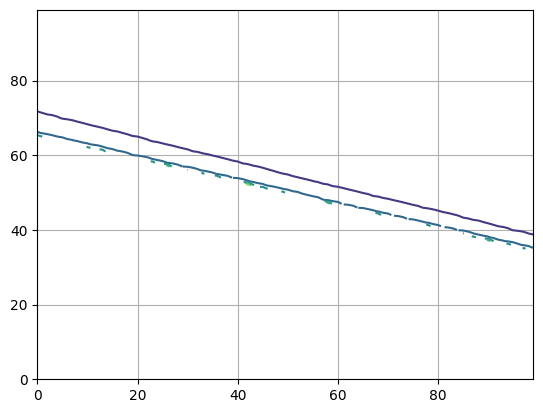

In [86]:
plt.contour(out_arr)
plt.grid()

In [ ]:
raise UserError('Stopping execution')

# Attempting a relaxation into a IPM stationary point (Doesn't work)

In [26]:
t = 1/tol_default

from jax import grad, jacfwd, jacrev, eval_shape

In [29]:
grad_f = grad(f_scaled)
jac_g = _choose_fwd_rev(
    g_scaled, 
    len(x_flat_init), # input shape
    eval_shape(g_scaled, x_flat_init).shape[0], # output shape 
    argnums=0
)

In [33]:
grad_f_opt = grad_f(x_flat_opt)
jac_g_opt = jac_g(x_flat_opt)
g_opt = g_scaled(x_flat_opt)

In [56]:
print('     active constraints #', jnp.sum(g_opt>=0))
print('near active constraints #', jnp.sum(g_opt>=-tol_default))

     active constraints # 14
near active constraints # 80


In [57]:
jac_g_opt.shape

(1157, 313)

In [97]:
# Let's inspect the span of the strictly active matrix:
active_matrix = np.array(jac_g_opt[g_opt>=- tol_default])
active_matrix.shape

(34, 313)

In [101]:
g_opt[-1]

Array(1.04993236e-09, dtype=float64)

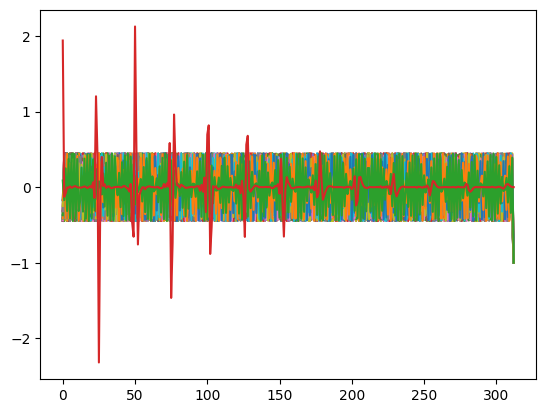

In [100]:
plt.plot(active_matrix.T)
print()

In [99]:
# coef is -1/t(c_i-g_i)
coefs, resid, _, _ = jnp.linalg.lstsq(jac_g_opt.T, -grad_f_opt)
# Because we are trying to re-write as a 
# strictly feasible IPM, c_i-g_i >= 0.
# Discard all positive entries.
coefs = jnp.maximum(coefs, 0)
jax.debug.print('Residual for the c_i linear equation: {x}', x=jnp.linalg.norm(jac_g_opt.T @ coefs - grad_f_opt))

Residual for the c_i linear equation: 2.172467076881648


## This doesn't work
We know that constraint `[-1]` is active because it's the $f_B$ constraint, 
but its corresponding row in $\nabla g$ is independent from $\nabla f$.
This is possibly due to the combination of 2 reasons:
1. Constraints can become inactive in auglag, even when they should be.
2. $\nabla f$'s direction is very sensitive to 
small perturbations in $x$ near the optimum
So, a near-optimum $f^*_{auglag}$ can have $\nabla f^*_{auglag}$
very different from that of $\nabla f^*$!!

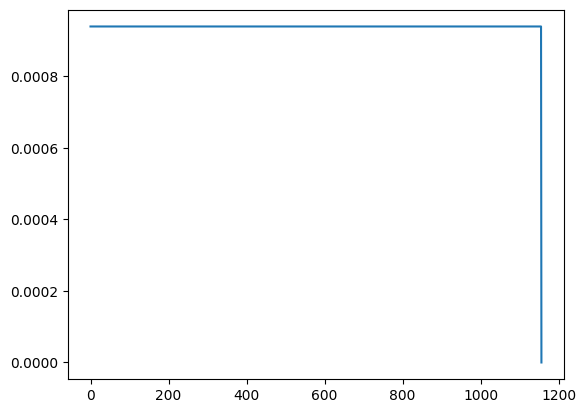

In [102]:
plt.plot(coefs)

In [91]:
coefs[-1]

Array(5.02531493e-19, dtype=float64)

NameError: name 'coef' is not defined

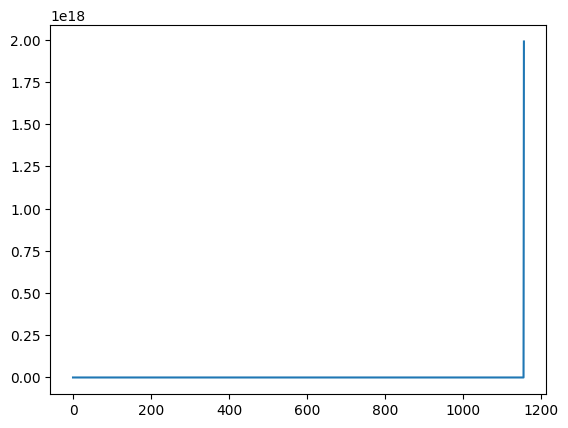

In [90]:
plt.plot(inv_coef)

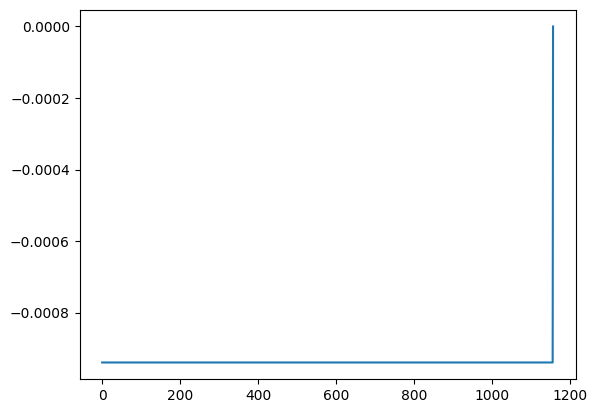

In [67]:
plt.plot(coefs)

In [68]:
resid

Array([1.17475991e-30], dtype=float64)

In [54]:
jnp.linalg.norm(grad_f_opt)

Array(1.08623354, dtype=float64)